# Functional Encryption - Classification and information leakage
 
We would like to have a measure of the leakage with cryptology notions. In particular, we will look at the notion of [advantage](https://en.wikipedia.org/wiki/Advantage_(cryptography)) in the distinction task.

> An adversary's advantage is a measure of how successfully it can attack a cryptographic algorithm, by distinguishing it from an idealized version of that type of algorithm -- Wikipedia


Let $Q$ be the real quadratic network, and let $Q_{ideal}$ be the real one with no collateral leakage (ie accuracy on the collateral task would be 50%). The adversary $F$ is a probabilistic algorithm given $Q$ or $Q_{ideal}$ as input and which outputs 1 or 0 (depending on the font). $F$'s job is to distinguish $Q$ from $Q_{ideal}$ based on making queries given data samples. We say: $Adv(F)=|\Pr[F(Q)=1]-\Pr[F(Q_{ideal})=1]|$

Because the adversary is sharp, it will fix a digit and try to distinguish on this one the font used. We chose $6$ because we are fair and wanted a digit of average difficulty.

So to be clear: when building the resistance, we must provide equal resistance against all kind of digits from the couple of fonts selected, but the adversary can be specilized in a single digit. Therefore the problem is a bit unbalanced and we expect worse results compared to the Part 6. Therefore, we already start with longer sabotage and attack phases to get a more realistic view of what we should expect.

# 8. Collateral Learning assessed with Advantage


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [11]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [12]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

In [13]:
torch.set_num_threads(4)

In [25]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 50
        self.new_adversary_epochs = 50
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

In [26]:
PRIVATE_OUTPUT_SIZE = 4
N_CHARS = 10
N_FONTS = 2

## 8.1 Loading $Q$ with resistance

In [27]:
class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [28]:
def build_resistance(model, alpha=0):
    """
    Perform a dual learning phase with sabotage
    """
    args = Parser()
    # We are just building Q so we don't need the 3rd phase, it will be assessed later!
    args.new_adversary_epochs = 0
    
    train_loader, test_loader = collateral.get_data_loaders(args)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.new_adversary_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        recover = epoch > args.epochs + args.sabotage_epochs
        if recover:
            print("(recover)")
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha, 
            initial_phase, perturbate, recover, False
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

We could use the same $Q$ than in part 6, but we could like a better resistance so we rebuild a new one.

In [29]:
path = '../data/models/quadconvnet_part8.pt'
model = CollateralNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.7
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Computing model...
Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.316642 Loss Font: 0.691577
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.885826 Loss Font: 0.668406
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.191249 Loss Font: 0.665525
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.015702 Loss Font: 0.617189

Test set: Accuracy Char : 7469/10000 (74.69%)
          Accuracy Font : 6420/10000 (64.20%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.690784 Loss Font: 0.638409
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.539922 Loss Font: 0.636215
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.257514 Loss Font: 0.546887
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.156619 Loss Font: 0.480885

Test set: Accuracy Char : 9057/10000 (90.57%)
          Accuracy Font : 7208/10000 (72.08%)
(initial phase)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.417077 Loss Font: 0.499057
Train Epoch: 3 [19200/60000 (32%)]	Lo

Train Epoch: 21 [19200/60000 (32%)]	Loss Char: 0.005419 Loss Font: 0.686884
Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000680 Loss Font: 0.684848
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.019290 Loss Font: 0.679321

Test set: Accuracy Char : 9855/10000 (98.55%)
          Accuracy Font : 5254/10000 (52.54%)
(perturbate)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.008475 Loss Font: 0.691906
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.002341 Loss Font: 0.681824
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.002091 Loss Font: 0.690711
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.003571 Loss Font: 0.676640

Test set: Accuracy Char : 9856/10000 (98.56%)
          Accuracy Font : 5164/10000 (51.64%)
(perturbate)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.009138 Loss Font: 0.676547
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.095897 Loss Font: 0.678817
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.009322 Loss Font: 0.682940
Train Epoch: 23 [57600/60000 (96%)]	Lo

Train Epoch: 41 [57600/60000 (96%)]	Loss Char: 0.001309 Loss Font: 0.692805

Test set: Accuracy Char : 9858/10000 (98.58%)
          Accuracy Font : 5162/10000 (51.62%)
(perturbate)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.014164 Loss Font: 0.683166
Train Epoch: 42 [19200/60000 (32%)]	Loss Char: 0.009846 Loss Font: 0.691398
Train Epoch: 42 [38400/60000 (64%)]	Loss Char: 0.045560 Loss Font: 0.694507
Train Epoch: 42 [57600/60000 (96%)]	Loss Char: 0.003755 Loss Font: 0.696024

Test set: Accuracy Char : 9856/10000 (98.56%)
          Accuracy Font : 5156/10000 (51.56%)
(perturbate)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.001273 Loss Font: 0.689363
Train Epoch: 43 [19200/60000 (32%)]	Loss Char: 0.001360 Loss Font: 0.690024
Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.001684 Loss Font: 0.701527
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.005455 Loss Font: 0.689002

Test set: Accuracy Char : 9850/10000 (98.50%)
          Accuracy Font : 5090/10000 (50.90%)
(perturbate)
Train Ep

## 8.2 Testing distinguishability againts multiples nets

We load the `Q` net that we have thoroughly built and it will be given to our new network structure

In [30]:
quadratic_model = model
quadratic_model.freeze('quad')

We now perform only the last phase with the new adversary, note that we change the data loader

In [31]:
fonts = ['cursive', 'Georgia']
letter = "6"

def evaluate_resistance(model, alpha=0):
    args = Parser()
    
    train_loader, test_loader = collateral.data.get_collateral_data_loaders(args, *fonts, letter)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        recover = True
        
        new_adversary = True
        
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha,
            initial_phase, perturbate, recover, new_adversary
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

Here is the basic structure of a network like those seen previously. There is a quadratic part which inherits from the `Q` loaded, and a method `conv_font` is left empty so that we can provide arbitrary adversary by inheriting from this `BaseNet`.

In [32]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [33]:
resistance_reports = {}

### 6.2.1 Fully connected models 

Here we inherit from BaseNet and we only have to specify `conv_font` and declare the layers used.

In [34]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = PRIVATE_OUTPUT_SIZE
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        


----- [64, 32, 16, 8]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694548
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.691868
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.684342
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692287

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5370/10000 (53.70%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674740
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.675577
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.693678
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.679803

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5392/10000 (53.92%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691726
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.679344
Train Epoch: 3

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.689091
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.704161
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.694054

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5453/10000 (54.53%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699829
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.640029
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.693341
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.687744

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5504/10000 (55.04%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687961
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.699321
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.702001
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692

Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.701459
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.698496

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5624/10000 (56.24%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677042
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.682734
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.700579
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690580

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5599/10000 (55.99%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667612
Train Epoch: 45 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.695124
Train Epoch: 45 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.708934
Train Epoch: 45 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690114

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 545

Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.673905

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5402/10000 (54.02%)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674690
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.690630
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.672594
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.670712

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5409/10000 (54.09%)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684778
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.687160
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.682288
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690218

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5427/10000 (54.27%)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.000000 Loss Fon

Train Epoch: 36 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.691780
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.670848
Train Epoch: 36 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.700079

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5459/10000 (54.59%)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693338
Train Epoch: 37 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.703227
Train Epoch: 37 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.682479
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.680384

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5486/10000 (54.86%)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688768
Train Epoch: 38 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.682867
Train Epoch: 38 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.694973
Train Epoch: 38 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.676

Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.672316
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.694473

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5356/10000 (53.56%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678635
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.694375
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698480
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.703435

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5383/10000 (53.83%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681822
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.670881
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.693596
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.684979

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5392/10000 (5

Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.678097

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5226/10000 (52.26%)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703617
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.708538
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.682365
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.694095

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5479/10000 (54.79%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.656985
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.682587
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.679170
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.667821

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5406/10000 (54.06%)
Train Epoch: 31 [0/60000 (0%)]	Loss Char: 0.000000 Loss Fon

Train Epoch: 50 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.688482
Train Epoch: 50 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.667873
Train Epoch: 50 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.654791

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5454/10000 (54.54%)

----- [64]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.835509
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.673352
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.664023
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.791994

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5215/10000 (52.15%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.665689
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.684628
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.697461
Train Epoch: 2 [5

Train Epoch: 21 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.709284
Train Epoch: 21 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.651682

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5455/10000 (54.55%)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688771
Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.706524
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.696494
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692655

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5486/10000 (54.86%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673117
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.635107
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.695051
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.722106

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 558

Train Epoch: 42 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.670361

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5552/10000 (55.52%)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684424
Train Epoch: 43 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.706208
Train Epoch: 43 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.693677
Train Epoch: 43 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692584

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5617/10000 (56.17%)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684894
Train Epoch: 44 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.691438
Train Epoch: 44 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.712765
Train Epoch: 44 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.713425

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5572/10000 (55.72%)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Fon

Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.694215
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.686275
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.668907

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5215/10000 (52.15%)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680658
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.694702
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.669605
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.675004

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5448/10000 (54.48%)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688676
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.684801
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687629
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695

Train Epoch: 35 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.712363
Train Epoch: 35 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.647565

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5404/10000 (54.04%)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.707730
Train Epoch: 36 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.693469
Train Epoch: 36 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.666661
Train Epoch: 36 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695366

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5392/10000 (53.92%)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702041
Train Epoch: 37 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.690162
Train Epoch: 37 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.685233
Train Epoch: 37 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.678595

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 546

Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.669694

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5391/10000 (53.91%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.704253
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.689520
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.674055
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696709

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5408/10000 (54.08%)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678411
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.694577
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.699404
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.696764

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5317/10000 (53.17%)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.67818

Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.683058
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.691707
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.677863

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5221/10000 (52.21%)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.710591
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.707948
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.681018
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.688870

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5492/10000 (54.92%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.644843
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.688545
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.676547
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.660

Train Epoch: 49 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.705843
Train Epoch: 49 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.660627

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5443/10000 (54.43%)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679293
Train Epoch: 50 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.678955
Train Epoch: 50 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.667245
Train Epoch: 50 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.665802

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5438/10000 (54.38%)


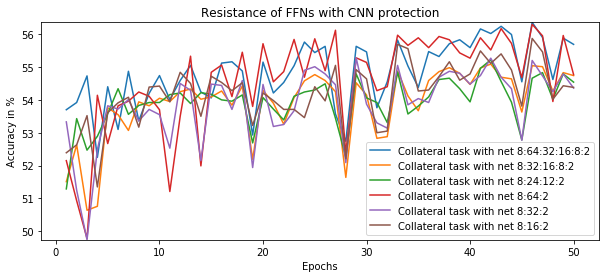

In [35]:
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]]

for architecture in architectures:
    print('\n-----', architecture)
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


### 6.2.2 CNN models

In [80]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(PRIVATE_OUTPUT_SIZE, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.767450
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.690480
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.689105
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.694280

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5377/10000 (53.77%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.662716
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.677280
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698464
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.681176

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5488/10000 (54.88%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.701480
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.672715
Train Epoch: 3 [38400/60000 (64%)]	Lo

Train Epoch: 22 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.689438
Train Epoch: 22 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.696754
Train Epoch: 22 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.678330

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5668/10000 (56.68%)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.651331
Train Epoch: 23 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.610693
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.673237
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.688039

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5687/10000 (56.87%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.704302
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.707063
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.714140
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.661

TypeError: object of type 'float' has no len()

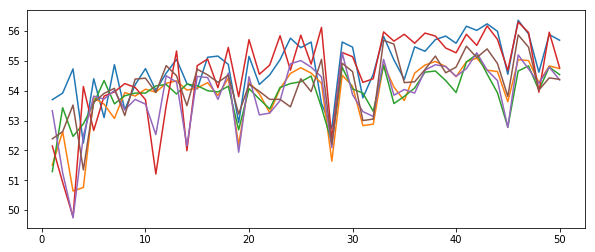

In [81]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    )
]
"""
,
    (
        nn.Conv2d(1, 30, 4, 1),
        nn.Conv2d(30, 100, 4),
        nn.Linear(100 * 4 * 4, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, N_FONTS)
    )
"""
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

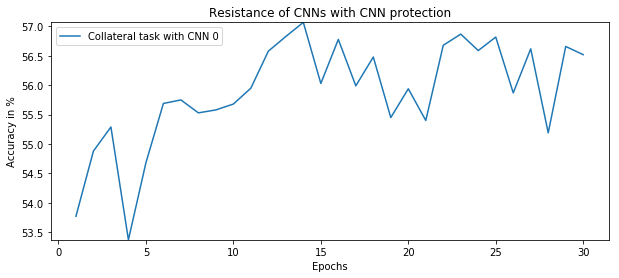

In [84]:
show_results(
    {k:v for k, v in resistance_reports.items() if 'CNN' in k}, 
    title="Resistance of CNNs with CNN protection"
)

## 6.3 Non-NN models

We now test many models from the sklearn library

### Data preparation

In [38]:
transform = BaseNet(quadratic_model)

In [39]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': N_CHARS, 'font': N_FONTS}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [40]:
train_dataset, test_dataset = collateral.data.get_datasets(None, None)
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [41]:
train_input = transform.quad(train_input).detach().numpy()
test_input = transform.quad(test_input).detach().numpy()

In [42]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

In [43]:
train_input.shape, train_label.shape

((60000, 4), torch.Size([60000]))

In [44]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [45]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [46]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

### Linear models

In [47]:
reg = linear_model.Ridge(alpha=.9)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Ridge'] = acc * 100

0.4966


In [48]:
reg = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100], cv=5)
acc = evaluate_sklearn(reg)
print(acc)

0.4966


In [49]:
reg = linear_model.Lasso(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Lasso'] = acc * 100

0.5005


In [50]:
reg = linear_model.LassoLars(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)

0.5005


In [51]:
reg = linear_model.BayesianRidge()
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

0.4964


In [52]:
reg = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', max_iter=1000)
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)
resistance_reports['logistic regression'] = acc * 100

0.4969


In [53]:
reg = linear_model.LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

0.4967


### Quadratic Discriminant Analysis

In [54]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [55]:
clf = QuadraticDiscriminantAnalysis()
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Quadratic Discriminant Analysis'] = acc * 100

0.5025


### Kernel Ridge

In [56]:
clf = kernel_ridge.KernelRidge(alpha=1.0)
limit = {'LOW': 15000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=1.85855e-09): result may not be accurate.
  overwrite_a=False)


0.5063


### SVM

In [57]:
clf = svm.SVC(gamma='scale', kernel='linear')
limit = {'LOW': 5000, 'MEDIUM': 15000, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])

print(acc)

0.5005


In [58]:
clf = svm.SVC(gamma='scale', kernel='rbf')
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['SVM (rbf)'] = acc * 100

0.532


In [59]:
clf = svm.SVC(gamma='scale', kernel='poly', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

0.5073


In [60]:
clf = svm.SVC(gamma='scale', kernel='sigmoid', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

0.5007


### Stochastic gradient Descent

In [61]:
clf = linear_model.SGDClassifier(loss="hinge", penalty="l2")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['SGDClassifier'] = acc * 100

0.4996


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [62]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss="log")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

0.5004


### K-Neighbors Classifier

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['K-Neighbors Classifier'] = acc * 100

0.5822


### Gaussian process (not scalable)

In [65]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [66]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0)
limit = {'LOW': 1700, 'MEDIUM': 5000, 'HIGH': 20000}
acc = evaluate_sklearn(gpc, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['Gaussian process'] = acc * 100

0.5005


### Naive Bayes

In [67]:
from sklearn.naive_bayes import GaussianNB

In [68]:

gnb = GaussianNB()
acc = evaluate_sklearn(gnb, one_hot=False)
print(acc)

0.4948


### Decision Tree Classifier

In [69]:
from sklearn.tree import DecisionTreeClassifier

In [70]:

clf = DecisionTreeClassifier(max_depth=5)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

resistance_reports['Decision Tree Classifier'] = acc * 100

0.5243


### Ensemble methods

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Random Forest Classifier'] = acc * 100

0.592


In [73]:
clf = AdaBoostClassifier(n_estimators=200, learning_rate=1.)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['AdaBoost Classifier'] = acc * 100

0.5401


In [74]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Gradient Boosting Classifier'] = acc * 100

0.5704


### (sklearn) Neural Network

In [75]:
from sklearn.neural_network import MLPClassifier

In [76]:
clf = MLPClassifier(solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(10, 40, 10), random_state=1)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

0.5289


## Summary

In [77]:
def print_table(results):
    n_cols = 2
    title_length = 0
    for title in results.keys():
        title_length = max(title_length, len(title))
    result_length = 8
    table_length = 1 + n_cols + title_length + result_length
    sep = '+'.join(
        ['', '-'*title_length, '-'*result_length, '']
    )
    for title, serie in results.items():
        print(sep)
        title = (title + ' '*title_length)[:title_length]
        if isinstance(serie, list):
            result = round(np.mean(serie[-4:]), 2)
        else:
            result = round(serie, 2)
        result = (' ' +str(result) + '%' + ' '*result_length)[:result_length]
        line = '|'.join(
            ['', title, result, '']
        )
        print(line)
    print(sep)

In [85]:
print_table(resistance_reports)

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 55.52% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 54.71% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 54.54% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 55.16% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 54.53% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 54.57% |
+---------------------------------------+--------+
|linear model Ridge                     | 49.66% |
+---------------------------------------+--------+
|linear model Lasso                     | 50.05% |
+---------------------------------------+--------+
|logistic regression                    | 49.69% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysi

### Compative results

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 55.52% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 54.71% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 54.54% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 55.16% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 54.53% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 54.57% |
+---------------------------------------+--------+
|linear model Ridge                     | 49.66% |
+---------------------------------------+--------+
|linear model Lasso                     | 50.05% |
+---------------------------------------+--------+
|logistic regression                    | 49.69% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 50.25% |
+---------------------------------------+--------+
|SVM (rbf)                              | 53.2%  |
+---------------------------------------+--------+
|SGDClassifier                          | 49.96% |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 58.22% | *
+---------------------------------------+--------+
|Gaussian process                       | 50.05% |
+---------------------------------------+--------+
|Decision Tree Classifier               | 52.43% |
+---------------------------------------+--------+
|Random Forest Classifier               | 59.2%  | *
+---------------------------------------+--------+
|AdaBoost Classifier                    | 54.01% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 57.04% | *
+---------------------------------------+--------+

## Conclusion

The long term resistance has proved to be very effective and the collateral accuracy we get is even lower than previous results of Part 6!
For Neural Networks the results are very good as we don't exceed 55-56%. For other models likes K-Neighbors or Random Forest, we observe also a significant drop as we get under 60%